# Prediction of the expected $\delta ^{34}S$ of environmental DMSP subject to cleavage (c) and demethylation (d), taking into account the fractionation factors determined in this study.

In [2]:
#For numerical calculations
import numpy as np
import operator
from scipy.integrate import odeint 
from scipy.optimize import fsolve
import pandas as pd
pd.set_option('display.precision',5)
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

#Import plotting features
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.tri as tri
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

%reload_ext blackcellmagic

We will begin by defining the equations required to calculate isotope ratios and delta values.

* Total DMSP will be assumed to be the sum of the DMSP with the two most common stable isotopes of S, $^{34}S$ and $^{32}S$:

$$
DMSP= {^{34}{DMSP}} + {^{32}{DMSP}}
\tag{1}
$$


* The isotopic ratio of $^{34}{DMSP}$ and $^{32}{DMSP}$ is:


$$
^{34}R_{DMSP} = \frac{^{34}{DMSP}}{^{32}{DMSP}} 
\tag{2}
$$


* The following expression allows to convert the previously calculated isotopic ratio to the delta notation ($\delta^{34}S$) which is the one commonly used by isotope geochemists since it allows direct comparisons of fractionation factors with isotopic compositions:

$$
\delta^{34}S = \left( \frac{^{34}R_{DMSP}}{^{34}R_{std}} -1 \right) * 1000
\tag{3}
$$

To determine what is the amount of $^{32}DMSP$ and $^{34}DMSP$ for a particular DMSP concentration or flux, we will define the following function:

In [3]:
def isotopes(c, r_34_std = 0.0450045, delta_in = 17):
    '''
    Function that splits a DMSP concentration in the proportion of
    heavy (34) and light (32) atoms.
    Parameters
    ----------
    c: float.
    Concentration of DMSP in nM.
    r_34_std: float.
    34R of the VCDT standard. Error = +-9.3
    delta_in: float.
    Delta 34S of newly synthesized DMSP. Assumed.
    Returns
    -------
    Concentration of 34DMSP, concentration of 32DMSP
    '''
        
    # Calculate 34R in DMSP from Eq. 3
    r_34_dmsp =r_34_std *(1+(delta_in/1000))
    # Calculate 32_DMSP from Eq. 2
    dmsp_32 = c/(1 + r_34_dmsp)
    # Calculate 34_DMSP from Eq. 1
    dmsp_34 = c - dmsp_32
        
    return [dmsp_34,dmsp_32]

Now, we will define the equations that will allow us to establish a mass balance of $^{32}DMSP$ and $^{34}DMSP$ in the ocean:

## Equations to determine how mass changes over time:

* The change in $^{34}DMSP$ will be given by the amount of $^{34}DMSP$ that flows into the system minus the amount of $^{34}DMSP$ that flows out the system:

$$
\frac {d^{34}{DMSP}}{dt}= {^{34}F_{in}} - {^{34}F_{out}}
\tag{4}
$$

* Similarly, the change in $^{32}DMSP$ will be given by the amount of $^{32}DMSP$ that flows into the system minus the amount of $^{32}DMSP$ that flows out the system:

$$
\frac {d^{32}{DMSP}}{dt}= {^{32}F_{in}} - {^{32}F_{out}}
\tag{5}
$$


## Equations that state the mass balance of the fluxes:

* The flux of DMSP into the ocean has been calculated and reported previously. We will use the value reported by Simó et al. (2009) for the Mediterranean Sea.


* The flux of DMSP out of the system will also be assumed to be the sum of DMSP with the two most common stable isotopes of S, $^{34}S$ and $^{32}S$. 

$$
{F}_{out} = {^{34}{F}_{out}} + {^{32}{F}_{out}}
\tag{6}
$$

* In turn, this would be equal to the flux of DMSP that is degraded by the sum of the two main degradation processes, cleavage and demethylation. For the purpose of simplification, no other degradation processes will be considered here.

$$
{F}_{out} = {F}_{out\;c} + {F}_{out\;d}
\tag{7}
$$

## Equations to define the kinetics of the degradation reactions:

The DMSP degradation reactions are assumed to follow Michaelis-Menten kinetics:

$$
{F}_{out} = {V_{max} \cdot DMSP \over K_{M} +DMSP}
\tag{8}
$$
Where ${F}_{out}$ is the flux of DMSP out of the system due to enzymatic degradation (reaction rate), $V_{max}$ is the maximal reaction rate, $K_{M}$ is the Michaelis-Menten constant, and DMSP is the concentration of DMSP.

The flux out of $^{32}DMSP$ and $^{34}DMSP$ will be given by equations 9 and 10, respectively:

$$
^{32}F_{out} = \frac{^{32}{V}_{max}\; {^{32}DMSP}}{^{32}{K}_{M}+^{32}DMSP}
\tag{9}
$$

$$
^{34}F_{out} = \frac{^{34}{V}_{max}\; {^{34}DMSP}}{^{34}{K}_{M}+^{34}DMSP}
\tag{10}
$$

Equations 9 and 10, can be respectively rewritten as equations 11 and 12:

$$
^{32}F_{out} = \frac{^{32}{V}_{max}}{^{32}K_M}
\left(\frac{^{32}{V}_{max}\; {^{32}DMSP}}{^{32}{V}_{max}+\left(
\frac{^{32}{V}_{max}}{^{32}K_M}\right) \; ^{32}DMSP}\right)
\tag{11}
$$

$$
^{34}F_{out} = \frac{^{34}{V}_{max}}{^{34}K_M}
\left(\frac{^{34}{V}_{max}\; {^{34}DMSP}}{^{34}{V}_{max}+\left(
\frac{^{34}{V}_{max}}{^{34}K_M}\right) \; ^{34}DMSP}\right)
\tag{12}
$$

## Definition of the fractionation factors:

* The fractionation factor between $^{34}S$ and $^{32}S$ in the DMSP that is enzymatically degraded is expected to have combined effects on $V_{max}$ and $K_{M}$ (they cannot be separated out). At steady state, for the DMSP degraded by cleavage, the fractionation factor would be:

$$
\alpha_{c} = \frac{^{34}{V}_{max\;c}/^{34}{K}_{M\;c}}{^{32}{V}_{max\;c}/^{32}{K}_{M\;c}}
\tag{13}
$$

* Similarly, at steady state the fractionation factor between $^{34}S$ and $^{32}S$ in the DMSP that is degraded by demethylation would be:
$$
\alpha_{d} = \frac{^{34}{V}_{max\;d}/^{34}{K}_{M\;d}}{^{32}{V}_{max\;d}/^{32}{K}_{M\;d}}
\tag{14}
$$

## Incorporation of the fractionation factors in the mass balance of DMSP

* The flux of DMSP with $^{32}S$ out of the system will be equal to the sum of the flux from cleavage and demethylation:

$$
^{32}F_{out} = ^{32}{F}_{out\;c\;(Alma1)}\cdot f_{out\;c\;(Alma1)} + 
^{32}{F}_{out\;c\;(DddP)}\cdot f_{out\;c\;(DddP)} + 
^{32}{F}_{out\;d}\cdot f_{out\;d}
\tag{15}
$$


$$
^{32}F_{out} = \frac{^{32}{V}_{max\;c\;(Alma1)}}{^{32}K_{M\;c\;(Alma1)}}
\left(\frac{^{32}{V}_{max\;c\;(Alma1)}\; {^{32}DMSP}}{^{32}{V}_{max\;c\;(Alma1)}+\left(
\frac{^{32}{V}_{max\;c\;(Alma1)}}{^{32}K_{M\;c\;(Alma1)}}\right) \; ^{32}DMSP}\right) \cdot f_{out\;c\;(Alma1)} +
\frac{^{32}{V}_{max\;c\;(DddP)}}{^{32}K_{M\;c\;(DddP)}}
\left(\frac{^{32}{V}_{max\;c\;(DddP)}\; {^{32}DMSP}}{^{32}{V}_{max\;c\;(DddP)}+\left(
\frac{^{32}{V}_{max\;c\;(DddP)}}{^{32}K_{M\;c\;(DddP)}}\right) \; ^{32}DMSP}\right) \cdot f_{out\;c\;(DddP)}+
\frac{^{32}{V}_{max\;d}}{^{32}K_{M\;d}}
\left(\frac{^{32}{V}_{max\;d}\; {^{32}DMSP}}{^{32}{V}_{max\;d}+\left(
\frac{^{32}{V}_{max\;d}}{^{32}K_{M\;d}}\right) \; ^{32}DMSP}\right) \cdot f_{out\;d}
\tag{16}
$$

* The flux of DMSP with $^{34}S$ out of the system will be equal to the sum of the flux from cleavage and demethylation:

$$
^{34}F_{out} = ^{34}{F}_{out\;c\;(Alma1)}\cdot f_{out\;c\;(Alma1)} + 
^{34}{F}_{out\;c\;(DddP)}\cdot f_{out\;c\;(DddP)} + 
^{34}{F}_{out\;d}\cdot f_{out\;d}
\tag{17}
$$

$$
^{34}F_{out} = \frac{^{34}{V}_{max\;c\;(Alma1)}}{^{34}K_{M\;c\;(Alma1)}}
\left(\frac{^{34}{V}_{max\;c\;(Alma1)}\; {^{34}DMSP}}{^{34}{V}_{max\;c\;(Alma1)}+\left(
\frac{^{34}{V}_{max\;c\;(Alma1)}}{^{34}K_{M\;c\;(Alma1)}}\right) \; ^{34}DMSP}\right) \cdot f_{out\;c\;(Alma1)} +
\frac{^{34}{V}_{max\;c\;(DddP)}}{^{34}K_{M\;c\;(DddP)}}
\left(\frac{^{34}{V}_{max\;c\;(DddP)}\; {^{34}DMSP}}{^{34}{V}_{max\;c\;(DddP)}+\left(
\frac{^{34}{V}_{max\;c\;(DddP)}}{^{34}K_{M\;c\;(DddP)}}\right) \; ^{34}DMSP}\right) \cdot f_{out\;c\;(DddP)}+
\frac{^{34}{V}_{max\;d}}{^{34}K_{M\;d}}
\left(\frac{^{34}{V}_{max\;d}\; {^{34}DMSP}}{^{34}{V}_{max\;d}+\left(
\frac{^{34}{V}_{max\;d}}{^{34}K_{M\;d}}\right) \; ^{34}DMSP}\right) \cdot f_{out\;d}
\tag{18}
$$

Assuming that $f_{out\;c\;(Alma1)} + f_{out\;c\;(DddP)} + f_{out\;d} = 1$

* We will define a kappa parameter, which is the ratio of $V_{max}$ to $K_M$ for each DMSP isotopologue:

$$
^{34}{\kappa} = \frac{^{34}{V}_{max}}{^{34}{K}_{M}}
\tag{19}
$$

$$
^{32}{\kappa} = \frac{^{32}{V}_{max}}{^{32}{K}_{M}}
\tag{20}
$$

Replacing kappa in the equations above:

$$
^{32}F_{out} = ^{32}{\kappa_{c\;(Alma1)}}
\left(\frac{^{32}{V}_{max\;c\;(Alma1)}\; {^{32}DMSP}}{^{32}{V}_{max\;c\;(Alma1)}+
^{32}{\kappa_{c\;(Alma1)}} \cdot ^{32}DMSP}\right) \cdot f_{out\;c\;(Alma1)} +
^{32}{\kappa_{c\;(DddP)}}
\left(\frac{^{32}{V}_{max\;c\;(DddP)}\; {^{32}DMSP}}{^{32}{V}_{max\;c\;(DddP)}+
^{32}{\kappa_{c\;(DddP)}} \cdot ^{32}DMSP}\right) \cdot f_{out\;c\;(DddP)}+
^{32}{\kappa_{d}}
\left(\frac{^{32}{V}_{max\;d}\; {^{32}DMSP}}{^{32}{V}_{max\;d}+
^{32}{\kappa_{d}} \cdot ^{32}DMSP}\right) \cdot f_{out\;d}
\tag{21}
$$

$$
^{34}F_{out} = ^{34}{\kappa_{c\;(Alma1)}}
\left(\frac{^{34}{V}_{max\;c\;(Alma1)}\; {^{34}DMSP}}{^{34}{V}_{max\;c\;(Alma1)}+
^{34}{\kappa_{c\;(Alma1)}} \cdot ^{34}DMSP}\right) \cdot f_{out\;c\;(Alma1)} +
^{34}{\kappa_{c\;(DddP)}}
\left(\frac{^{34}{V}_{max\;c\;(DddP)}\; {^{34}DMSP}}{^{34}{V}_{max\;c\;(DddP)}+
^{34}{\kappa_{c\;(DddP)}} \cdot ^{34}DMSP}\right) \cdot f_{out\;c\;(DddP)}+
^{34}{\kappa_{d}}
\left(\frac{^{34}{V}_{max\;d}\; {^{34}DMSP}}{^{34}{V}_{max\;d}+
^{34}{\kappa_{d}} \cdot ^{34}DMSP}\right) \cdot f_{out\;d}
\tag{22}
$$

Finally, we will replace Eq. 21 and Eq. 22 back in Eq. 4 and 5 to get an expression of the mass balance of $^{32}DMSP$ and $^{34}DMSP$ due to the DMSP fluxes in the ocean:

$$
\frac {d^{32}{DMSP}}{dt}= {^{32}F_{in}} - \left(^{32}{\kappa_{c\;(Alma1)}}
\left(\frac{^{32}{V}_{max\;c\;(Alma1)}\; {^{32}DMSP}}{^{32}{V}_{max\;c\;(Alma1)}+
^{32}{\kappa_{c\;(Alma1)}} \cdot ^{32}DMSP}\right) \cdot f_{out\;c\;(Alma1)} +
^{32}{\kappa_{c\;(DddP)}}
\left(\frac{^{32}{V}_{max\;c\;(DddP)}\; {^{32}DMSP}}{^{32}{V}_{max\;c\;(DddP)}+
^{32}{\kappa_{c\;(DddP)}} \cdot ^{32}DMSP}\right) \cdot f_{out\;c\;(DddP)}+
^{32}{\kappa_{d}}
\left(\frac{^{32}{V}_{max\;d}\; {^{32}DMSP}}{^{32}{V}_{max\;d}+
^{32}{\kappa_{d}} \cdot ^{32}DMSP}\right) \cdot f_{out\;d}\right)
\tag{23}
$$

$$
\frac {d^{34}{DMSP}}{dt}= {^{34}F_{in}} - \left(^{34}{\kappa_{c\;(Alma1)}}
\left(\frac{^{34}{V}_{max\;c\;(Alma1)}\; {^{34}DMSP}}{^{34}{V}_{max\;c\;(Alma1)}+
^{34}{\kappa_{c\;(Alma1)}} \cdot ^{34}DMSP}\right) \cdot f_{out\;c\;(Alma1)} +
^{34}{\kappa_{c\;(DddP)}}
\left(\frac{^{34}{V}_{max\;c\;(DddP)}\; {^{34}DMSP}}{^{34}{V}_{max\;c\;(DddP)}+
^{34}{\kappa_{c\;(DddP)}} \cdot ^{34}DMSP}\right) \cdot f_{out\;c\;(DddP)}+
^{34}{\kappa_{d}}
\left(\frac{^{34}{V}_{max\;d}\; {^{34}DMSP}}{^{34}{V}_{max\;d}+
^{34}{\kappa_{d}} \cdot ^{34}DMSP}\right) \cdot f_{out\;d}\right)
\tag{24}
$$

Let's define a function to calculate the change in the concentrations of $^{32}DMSP$ and $^{34}DMSP$ over time, based on the two previous equations. 

In [4]:
def dmsp_system_3_comp_mm(
    c, 
    t,
    f_total_in, 
    alpha_d,
    alpha_c1,
    alpha_cp,
    kappa_32_d, 
    kappa_32_c1,
    kappa_32_cp,
    vmax_34_d,
    vmax_34_c1,
    vmax_34_cp,
    vmax_32_d,
    vmax_32_c1,
    vmax_32_cp,
    transcripts_d,
    transcripts_c1,
    transcripts_cp
):
    """
    Function that computes dD32_dt and dD34_dt of DMSP
    Parameters
    ----------
    c: float.
    Concentration of DMSP in nM.
    t: int
    Integration time in min.
    f_total_in: float. 
    [DMSP] that enters the system in nmol/min. Range: 0.2-2.5 nmol/l/h. From Simo et al. (2009)
    alpha_d: float.
    Alpha for demethylation from this study. 
    Epsilon has an error of +-0.17
    alpha_c1: float.
    Alpha for cleavage by Alma1 from this study. 
    Epsilon has an error of +-0.06
    alpha_cp: float.
    Alpha for cleavage from this study. 
    Epsilon has an error of +-0.14 
    kappa_32_d:float.
    Ratio of 32^V_max to 32^K_M for demethylation in l/min/mg enz. 
    kappa_32_c1:float.
    Ratio of 32^V_max to 32^K_M for cleavage by Alma1 in l/min/mg enz. 
    kappa_32_cp:float.
    Ratio of 32^V_max to 32^K_M for cleavage by DddP in l/min/mg enz. 
    vmax_34_d: int.
    34^V_max for demethylation in nmol/min/mg enz.
    vmax_34_c1: int.
    34^V_max for cleavage by Alma1 in nmol/min/mg enz.
    vmax_34_cp: int.
    34^V_max for cleavage by DddP in nmol/min/mg enz.
    vmax_32_d: int.
    32^V_max for demethylation in nmol/min/mg enz.
    vmax_32_c1: int.
    32^V_max for cleavage by Alma1 in nmol/min/mg enz.
    vmax_32_cp: int.
    32^V_max for cleavage by DddP in nmol/min/mg enz.
    transcripts_d: int.
    Concentration of DmdA (demethylase) in the ocean from Varaljay et al. (2015).
    Units of mRNA/l.
    transcripts_c1: int.
    Concentration of DMSP lyase in the ocean from approximation based on Vorobev et al. (2020)
    Units of mRNA/l.
    transcripts_cp: int.
    Concentration of DMSP lyase in the ocean from Varaljay et al. (2015)
    Units of mRNA/l.

    Returns
    -------
    The dD32_dt and dD34_dt of DMSP
    """
    # Unpack isotopes
    dmsp_34, dmsp_32 = c
    #Flux in of each DMSP
    f_34_in, f_32_in = isotopes(f_total_in)
    
    #Determination of kappa 34 for cleavage by Alma1 from kappa 32 and the fractionation factor
    kappa_34_c1 = kappa_32_c1 * alpha_c1 
    #Determination of kappa 34 for cleavage by DddP from kappa 32 and the fractionation factor
    kappa_34_cp = kappa_32_cp * alpha_cp 
    #Determination of kappa 34 for demethylation from kappa 32 and the fractionation factor
    kappa_34_d = kappa_32_d * alpha_d 
    
    # Calculate enzyme concentrations in units of mg/L
    # Final 1000 is the conversion of grams to milligrams. 

    dmda = prots_mrna*transcripts_d*(1/avog_n)*dmda_w*1000
    alma1 = prots_mrna*transcripts_c1*(1/avog_n)*alma1_w*1000
    dddp = prots_mrna*transcripts_cp*(1/avog_n)*dddp_w*1000
    
    #Calculate flux out of 32^DMSP in units of nmol/min 
    f_32_out = ((kappa_32_c1 * alma1 * (vmax_32_c1 * dmsp_32/((vmax_32_c1)+(kappa_32_c1 * dmsp_32))))+
                (kappa_32_cp * dddp * (vmax_32_cp * dmsp_32/((vmax_32_cp)+(kappa_32_cp * dmsp_32))))+
                (kappa_32_d * dmda * (vmax_32_d * dmsp_32/((vmax_32_d)+(kappa_32_d* dmsp_32)))))*ocean_vol
    
    # Calculate dD32_dt in units of nmol/l/min
    dD32_dt = (f_32_in - f_32_out)/ocean_vol
    
    #Calculate flux out of 34^DMSP in units of nmol/min
    f_34_out = ((kappa_34_c1 * alma1 * (vmax_34_c1 * dmsp_34/((vmax_34_c1)+(kappa_34_c1 * dmsp_34))))+
                (kappa_34_cp * dddp * (vmax_34_cp * dmsp_34/((vmax_34_cp)+(kappa_34_cp * dmsp_34))))+
                (kappa_34_d * dmda * (vmax_34_d * dmsp_34/((vmax_34_d)+(kappa_34_d * dmsp_34)))))*ocean_vol
    # Calculate dD34_dt in units of nmol/l/min
    dD34_dt = (f_34_in - f_34_out)/ocean_vol
    
    return [dD34_dt, dD32_dt]

We will define important variables that will be incorporated in the calculation, as well as integration parameters.

In [5]:
#Number of proteins/mRNA. 
prots_mrna = 1000
#Avogadro number
avog_n=6.022E23

#Weight of DmdA in g/mol
dmda_w=39.5E3
#Weight of DddP in g/mol
dddp_w=50E3
#Weight of Alma1 in g/mol
alma1_w=160E3

#Other variables
#Ocean volume in liters
ocean_vol = 1.3E21
#Order of magnitude estimate of the proportion of enzyme relative to total protein in the cell
total_prot_enzyme_ratio = 1/1E-6
#Average DMSP concentration in nM
dmsp_ocean = 10
#Isotopic composition of DMSP in the ocean from the isotopes function
isotopes_ini=isotopes(dmsp_ocean)

# Set parameters for integration
#Initial concentration of DMSP in nM
c = isotopes(10)
# Flux of DMSP into the ocean in nmol/l/min from Simó et al. (2019)
#(Annual average for the Mediterranean)
f_in = (0.000015/60)
# Volume of the surface ocean in liters, assuming a depth of 200 m
surface_ocean_vol = 7.24E19
# Flux of DMSP into the ocean in nmol/l/min
f_total_in = f_in*surface_ocean_vol

#Fractionation factors determined in this study
#For DmdA
alpha_d = (-2.72/1000)+1
# For Alma1
alpha_c1 = (-1.18/1000)+1
# For DddP
alpha_cp = (-3.97/1000)+1

# Define the 34R of the standard
r_34_std = 0.0450045
#Define the time points for integration
t = np.linspace(0, 1E10, 1000)

Based on the lower estimates of the kinetic parameters for the enzymes in the native organisms reported by Jonkers et al. (2000) and Stefels et al. (2007), we will calculate the lower limit for $V_{max}$ and $V_{max}/ K_M$ of each enzyme for open ocean conditions.

In [6]:
#V_max in units of nmol/min/mg cell protein
# K_M in nM
#DmdA
vmax_d = 0.089*1000 
km_d = 15500
#Alma1
vmax_c1 = 0.011*1000 
km_c1 = 500000
#DddP
vmax_cp = 0.0144*1000 
km_cp = 70000

#Calculation of Vmax in nmol/min/mg enzyme
vmax_enz_c1 = (vmax_c1*total_prot_enzyme_ratio)
vmax_enz_d = (vmax_d*total_prot_enzyme_ratio)
vmax_enz_cp = (vmax_cp*total_prot_enzyme_ratio)

#Determination of the real ratio of Vmax/kM in l/min/mg enz
ratio_cp = vmax_enz_cp/(km_cp)
ratio_c1 = vmax_enz_c1/(km_c1)
ratio_d = vmax_enz_d/(km_d)

#Append to dataframe
d_low = {'Enzyme': ['Alma1', 'DddP', 'DmdA'],
     '$V_{max} (nmol/min/mg enz)$': [vmax_enz_c1, vmax_enz_cp, vmax_enz_d], 
    '$V_{max}/K_M (l/min/mg\ enz)$': [ratio_c1, ratio_cp, ratio_d]}

df_params_low = pd.DataFrame(data=d_low)
df_params_low

,Enzyme,$V_{max} (nmol/min/mg enz)$,$V_{max}/K_M (l/min/mg\ enz)$
0,Alma1,11000000.0,22.00000
1,DddP,14400000.0,205.71429
2,DmdA,89000000.0,5741.93548


Now, we will use the upper estimates of the kinetic parameters for the enzymes in the native organisms upper limit for $V_{max}$ and $V_{max}/ K_M$ of each enzyme for open ocean conditions.

In [7]:
#V_max in units of nmol/min/mg cell protein
# K_M in nM
#DmdA
vmax_d = 0.3*1000
km_d = 4100 
#Alma1
vmax_c1 = 0.0835*1000
km_c1 = 12000
#DddP
vmax_cp = 0.0201*1000
km_cp = 20000 

#Calculation of Vmax in nmol/min/mg enzyme
vmax_enz_c1 = (vmax_c1*total_prot_enzyme_ratio)
vmax_enz_d = (vmax_d*total_prot_enzyme_ratio)
vmax_enz_cp = (vmax_cp*total_prot_enzyme_ratio)

#Determination of the real ratio of Vmax/kM in l/min/mg enz
ratio_cp = vmax_enz_cp/(km_cp)
ratio_c1 = vmax_enz_c1/(km_c1)
ratio_d = vmax_enz_d/(km_d)

#Append to dataframe
d_high = {'Enzyme': ['Alma1', 'DddP', 'DmdA'],
     '$V_{max} (nmol/min/mg enz)$': [vmax_enz_c1, vmax_enz_cp, vmax_enz_d], 
    '$V_{max}/K_M (l/min/mg\ enz)$': [ratio_c1, ratio_cp, ratio_d]}

df_params_high = pd.DataFrame(data=d_high)
df_params_high

,Enzyme,$V_{max} (nmol/min/mg enz)$,$V_{max}/K_M (l/min/mg\ enz)$
0,Alma1,8.35000e+07,6958.33333
1,DddP,2.01000e+07,1005.00000
2,DmdA,3.00000e+08,73170.73171


We will integrate Eqs. 23 and 24 until they reach steady state, to predict the expected values of $\delta^{34}S$ that DMSP in the ocean would reach under a constant influx of DMSP from biosynthesis and constant cleavage and demethylation processes degrading it. We will first vary the activity of each enzyme in terms of their number of transcripts.

## Expected $\delta ^{34}S$ of environmental DMSP when the DMSP degrading enzymes are assumed to have a variable number of transcripts

We will begin by defining the Michaelis-Menten parameters.

In [8]:
#Kappa (Vmax/K_M) in l/min/mg enz. Min and max reported values
#DmdA
# kappa_32_d=5744.19
# #kappa_32_d=73170.7
# #Alma1
# kappa_32_c1 = 22.2
# #kappa_32_c1= 6958.3
# #DddP
# kappa_32_cp= 205.7
# #kappa_32_cp= 1005  

#Kappa in l/min/mg enz. Intermediate value
# We will assume that kappa_32 ~ kappa
#DmdA
#kappa_32_d=10000/2
kappa_32_d=10000
#Alma1
#kappa_32_c1 = 2000/2
kappa_32_c1 = 2000
#DddP
#kappa_32_cp= 600/2
kappa_32_cp= 600

#V max in nmol/min/mg enz. The values were selected at an intermediate value 
#between the reported extreme values of Vmax for each enzyme. 
# We will assume that in all cases 34^V_max ~ 32^V_max
#Similar results were obtained when V_max ~ 32^V_max

#DmdA
vmax_34_d = 1E7/2
#Alma1
vmax_34_c1 = 4E7/2
#DddP
vmax_34_cp = 9E7/2
#DmdA
vmax_32_d = 1E7/2
#Alma1
vmax_32_c1 = 4E7/2
#DddP
vmax_32_cp = 9E7/2

#Transcripts in mRNA/L.
#Alma1
transcripts_c1 = np.linspace(0,3E7,20)
#DddP
transcripts_cp = np.linspace(0,3E7,20)

Now, we will perform the numerical integration with ODEINT.

In [14]:
#Create empty lists
DMSP_34 = []
DMSP_32 = []
#Fraction of DMSP degraded by Alma1
fr_alma1=[]
#Fraction of DMSP degraded by DddP
fr_dddp=[]
#Fraction of DMSP degraded by DmdA
fr_dmda = []
#Ttotal DMSP degraded
total = []
#Loop through values of fraction of DMSP cleaved by Alma1
for i in transcripts_c1:
    #Loop through values of fraction of DMSP cleaved by DddP
    for j in transcripts_cp:
        #Calculate the fraction of degradation of DmdA
        transcripts_d=(3E7)-i-j
        #Determine the sum of fraction of DMSP degraded by Alma1 and DddP
        total_temp = i+j+transcripts_d
        #If the previously calculated sum is less than 3E7
        if (total_temp <=3E7 and transcripts_d>=0): 
        #Integrate
            dmsp_iso = odeint(dmsp_system_3_comp_mm, c, t, args= (
                f_total_in,
                alpha_d,
                alpha_c1,
                alpha_cp,
                kappa_32_d, 
                kappa_32_c1,
                kappa_32_cp,
                vmax_34_d,
                vmax_34_c1,
                vmax_34_cp,
                vmax_32_d,
                vmax_32_c1,
                vmax_32_cp,
                transcripts_d,
                i,
                j, 
                )
             )
            #Calculate the fraction of DMSP degraded by each enzyme
            #Alma1
            fr_1 = i/3E7
            #DddP
            fr_p = j/3E7
            #DmdA
            fr_a = transcripts_d/3E7
            #Append 34^DMSP and 32^DMSP to empty lists
            DMSP_34.append(dmsp_iso[-1,0])
            DMSP_32.append(dmsp_iso[-1,1])
            #Append total and fractions degraded by each enzyme in each iteration to empty list
            total.append(total_temp)
            fr_alma1.append(fr_1)
            fr_dddp.append(fr_p)
            fr_dmda.append(fr_a)

We will determine the $\delta ^{34}S$ values of DMSP. from the previously calculated concentrations of $^{32}DMSP$ and $^{34}DMSP$ at each time of the integration, and then append the values to a dataframe. This dataframe will also include the fractions degraded by each enzyme which rendered the different $\delta ^{34}S$ values of DMSP.

In [15]:
# Calculate 34R
r_34 = [x/y for x, y in zip (DMSP_34,DMSP_32)]

#Calculate d34S
#Create empty list
d34s_int = []
#Loop through 34^R
for i in r_34:
    #Calculate d34S
    d34s = ((i/r_34_std)-1)*1000
    #Append lin. app. to empty list
    d34s_int.append(d34s)

#Create dataframe with the information from the integration
df_dmsp_system_transcripts = pd.DataFrame(
    {'fr_alma1': fr_alma1,
     'fr_dddp': fr_dddp,
     'fr_dmda': fr_dmda,
     'd34S': d34s_int
    })
df_dmsp_system_transcripts.head()

,fr_alma1,fr_dddp,fr_dmda,d34S
0,0.0,0.00000,1.00000,19.77378
1,0.0,0.05263,0.94737,19.77915
2,0.0,0.10526,0.89474,19.78510
3,0.0,0.15789,0.84211,19.79173
4,0.0,0.21053,0.78947,19.79916


In [25]:
#Export the previous dataframe
df_dmsp_system_transcripts.to_csv(f'{homedir}/data/modelling/expected_d34s_DMSP_variable_enz_transcripts.csv')

In [17]:
#Convert lists to arrays for the plot
fr_dddp = np.asarray(df_dmsp_system_transcripts['fr_dddp'])
fr_dmda = np.asarray(df_dmsp_system_transcripts['fr_dmda'])
fr_alma1 = np.asarray(df_dmsp_system_transcripts['fr_alma1'])
d34s_int = np.asarray(df_dmsp_system_transcripts['d34S'])

Finally, we can make a ternary plot for the fractional contributions of DmdA, DddP and Alma1 to the predicted $\delta ^{34}S$ of DMSP, with a variable number of transcripts of each enzyme.

Text(0, 0.5, '$f_{Alma1\\;left} | f_{DmdA\\;right}$')

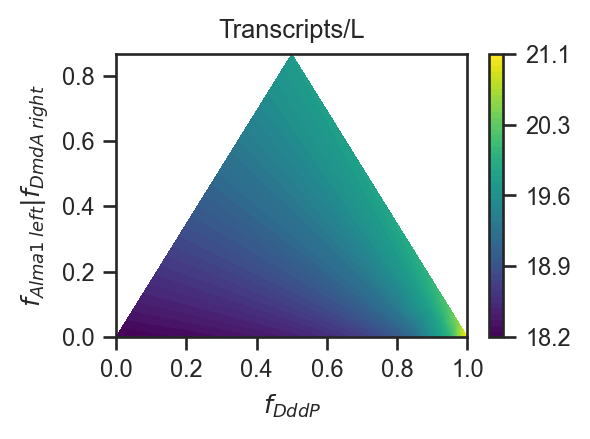

In [18]:
# Translate the data to Cartesian coordinates
x = 0.5 * ( 2.*fr_dddp+fr_dmda) / (fr_alma1+fr_dddp+fr_dmda )
y = 0.5*np.sqrt(3) * fr_dmda / (fr_alma1+fr_dddp+fr_dmda)

#Create very small intervals for the contours to soften them
tlev = np.linspace(d34s_int.min(),d34s_int.max())

# Create a triangulation out of these points
T = tri.Triangulation(x,y)

# Create figure and define size
fig, ax = plt.subplots(figsize=(2.95, 1.95), dpi=192)

# Plot the contour
plot_tr = plt.tricontourf(x,y,T.triangles,d34s_int, levels=tlev, cmap='viridis')

#Add colorbar
cbar = fig.colorbar(plot_tr,format="%.1f")
#Fix colorbar
cbar_ticks = np.linspace(d34s_int.min(),d34s_int.max(), num=5)
cbar.set_ticks(cbar_ticks)

#Set the right number of ticks on the x axis
ax.set_xticks (np.linspace(0,1,6))

#Set labels 
plt.title('Transcripts/L')
plt.xlabel('$f_{DddP}$')
plt.ylabel('$f_{Alma1\;left} | f_{DmdA\;right}$')

#Save plot to pdf
fig.savefig(f'{homedir}/figures/modelling/ternary_model_tc.pdf', bbox_inches='tight')

## Expected $\delta ^{34}S$ of environmental DMSP when the DMSP degrading enzymes are assumed to have a variable $V_{max}/K_M$ (kappa)

We will begin by defining the Michaelis-Menten parameters.

In [19]:
#Kappa in l/min/mg enz. Min and max reported values
#DmdAa
#kappa_32_d=5744.19
#kappa_32_d=73170.7
#Alma1
#kappa_32_c1 = 22.2
#kappa_32_c1= 6958.3
#DddP
#kappa_32_cp= 205.7
#kappa_32_cp= 1005  

#V max in nmol/min/mg enz. The values were selected at an intermediate value 
#between the reported extreme values of Vmax for each enzyme. We will assume that in all cases
#34^V_max ~ 32^V_max
#DmdA
vmax_34_d = 1E7/2
#Alma1
vmax_34_c1 = 1E7/2
#DddP
vmax_34_cp = 1E7/2

#DmdA
vmax_32_d = 1E7/2
#Alma1
vmax_32_c1 = 1E7/2
#DddP
vmax_32_cp = 1E7/2

#Number of transcripts/L of each enzyme
#Alma1
transcripts_c1 = 1E4
#DddP
transcripts_cp = 1E4
#DmdA
transcripts_d = 1E4

#Kappa in l/min/mg enz. Intermediate value
#Alma1
kappa_32_c1 = np.linspace(0,1E6,50)
#DddP
kappa_32_cp = np.linspace(0,1E6,50)

Now, we will perform the numerical integration with ODEINT.

In [20]:
# Integrate numerically with ODEint

#Create empty lists
DMSP_34 = []
DMSP_32 = []
fr_alma1=[]
fr_dddp=[]
fr_dmda = []
total = []
#Loop through values of fraction of DMSP cleaved by Alma1
for i in kappa_32_c1:
    #Loop through values of fraction of DMSP cleaved by DddP
    for j in kappa_32_cp:
        #Calculate the fraction of degradation of DmdA
        kappa_32_d = (1E6)-i-j
        #Determine the sum of fraction of DMSP degraded by Alma1 and DddP
        total_temp = i+j+kappa_32_d
        #If the previously calculated sum is less than 3E7
        if (total_temp <= 1E6 and  kappa_32_d >= 0): 
        #Integrate
            dmsp_iso = odeint(dmsp_system_3_comp_mm, c, t, args= (
                f_total_in,
                alpha_d,
                alpha_c1,
                alpha_cp,
                kappa_32_d, 
                i,
                j,
                vmax_34_d,
                vmax_34_c1,
                vmax_34_cp,
                vmax_32_d,
                vmax_32_c1,
                vmax_32_cp,
                transcripts_d,
                transcripts_c1,
                transcripts_cp
                )
             )
            #Calculate the fraction of DMSP degraded by each enzyme
            fr_1 = i/1E6
            fr_p = j/1E6
            fr_a = kappa_32_d/1E6
            #Append 34^DMSP and 32^DMSP to empty lists
            DMSP_34.append(dmsp_iso[-1,0])
            DMSP_32.append(dmsp_iso[-1,1])
            #Append total and fractions degraded by each enzyme in each iteration to empty list
            total.append(total_temp)
            fr_alma1.append(fr_1)
            fr_dddp.append(fr_p)
            fr_dmda.append(fr_a)

We will determine the $\delta ^{34}S$ values of DMSP. from the previously calculated concentrations of $^{32}DMSP$ and $^{34}DMSP$ at each time of the integration, and then append the values to a dataframe. This dataframe will also include the fractions degraded by each enzyme which rendered the different $\delta ^{34}S$ values of DMSP.

In [21]:
# Calculate 34R
r_34 = [x/y for x, y in zip (DMSP_34,DMSP_32)]

#Calculate d34S
#Create empty list
d34s_int = []
#Loop through 34^R
for i in r_34:
    #Calculate d34S
    d34s = ((i/r_34_std)-1)*1000
    #Append lin. app. to empty list
    d34s_int.append(d34s)

#Create dataframe with the information from the integration
df_dmsp_system_vmax_km = pd.DataFrame(
    {'fr_alma1': fr_alma1,
     'fr_dddp': fr_dddp,
     'fr_dmda': fr_dmda,
     'd34S': d34s_int
    })
df_dmsp_system_vmax_km.head()

,fr_alma1,fr_dddp,fr_dmda,d34S
0,0.0,0.00000,1.00000,19.76983
1,0.0,0.02041,0.97959,19.80288
2,0.0,0.04082,0.95918,19.83555
3,0.0,0.06122,0.93878,19.86788
4,0.0,0.08163,0.91837,19.89985


In [22]:
#Export the previous dataframe
df_dmsp_system_vmax_km.to_csv(f'{homedir}/data/modelling/expected_d34s_DMSP_variable_enz_vmax_km.csv')

In [23]:
#Convert lists to arrays for the plot
fr_dddp = np.asarray(df_dmsp_system_vmax_km['fr_dddp'])
fr_dmda = np.asarray(df_dmsp_system_vmax_km['fr_dmda'])
fr_alma1 = np.asarray(df_dmsp_system_vmax_km['fr_alma1'])
d34s_int = np.asarray(df_dmsp_system_vmax_km['d34S'])

Finally, we can make a ternary plot for the fractional contributions of DmdA, DddP and Alma1 to the predicted $\delta ^{34}S$ of DMSP, with a variable number of $^{32}V_{max}/^{32}K_M$ for each enzyme.

Text(0, 0.5, '$f_{Alma1\\;left} | f_{DmdA\\;right}$')

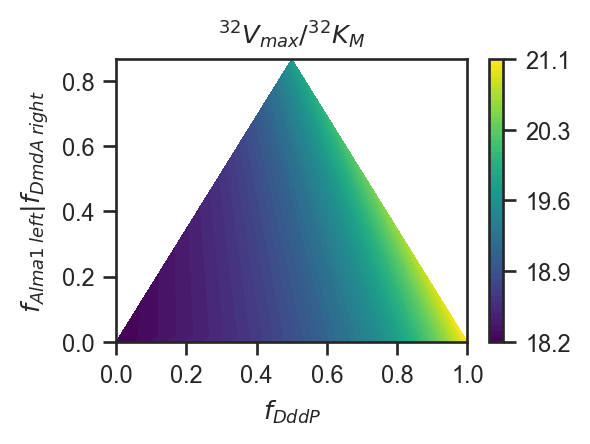

In [24]:
# Translate the data to Cartesian coordinates
x = 0.5 * (2.*fr_dddp+fr_dmda) / (fr_alma1+fr_dddp+fr_dmda)
y = 0.5*np.sqrt(3) * fr_dmda / (fr_alma1+fr_dddp+fr_dmda)

#Create very small intervals for the contours to soften them
tlev = np.linspace(d34s_int.min(),d34s_int.max())

# Create a triangulation out of these points
T = tri.Triangulation(x,y)

# Create figure and define size
fig, ax = plt.subplots(figsize=(2.95, 1.95), dpi=192)

# Plot the contour
plot_tr = plt.tricontourf(x,y,T.triangles,d34s_int, levels=tlev, cmap='viridis')

#Add colorbar
cbar = fig.colorbar(plot_tr,format="%.1f")
#Fix colorbar
cbar_ticks = np.linspace(d34s_int.min(),d34s_int.max(), num=5)
cbar.set_ticks(cbar_ticks)

#Set the right number of ticks on the x axis
ax.set_xticks (np.linspace(0,1,6))

#Set labels 
plt.title('$^{32}V_{max}/^{32}K_{M}$')
plt.xlabel('$f_{DddP}$')
plt.ylabel('$f_{Alma1\;left} | f_{DmdA\;right}$')

#Save plot to pdf
fig.savefig(f'{homedir}/figures/modelling/ternary_model_kappa.pdf', bbox_inches='tight')

We can see that both plots are very similar, which is expected since both show the expected $\delta^{34}S$ values of DMSP based on  which enzymes have the largest activities. 